In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import glob
import os
import itertools
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.set_option('display.max_row', 10)
pd.set_option('display.float_format', '{:.1f}'.format)
sns.set_style('darkgrid')

In [2]:
# get the data via url
df = pd.read_csv('https://storage.googleapis.com/mledu-datasets/mnist_train_small.csv', sep = ',', header = None)
# randomly reindex the data frame
df = df.reindex(np.random.permutation(df.index))
# use just the first 10000 examples for training and validation
df = df.head(10000)

or could download the file to local directory using `curl`

```python
!curl -O https://storage.googleapis.com/mledu-datasets/mnist_train_small.csv
pd.read_cvs('mnist_train_small.csv', sep = ',')
```

## visualize some of the training sets

In [3]:
def random_glance(df, n = 9):
    '''
    Randomly select n number of examples to show their images
    '''
    row = int(math.sqrt(n))
    col = math.ceil(n/row)
    fig, axes = plt.subplots(row, col, dpi = 100)
    inds = np.random.choice(df.index, n)
    for i, j in itertools.product(range(row), range(col)):
        n -= 1
        axes[i][j].imshow(df.loc[inds[n], 1:].values.reshape(28, 28), interpolation = 'nearest', cmap = 'Greys')
        axes[i][j].set_title('Lable: %d' %df.loc[inds[n], 0])
        axes[i][j].axes.xaxis.set_ticklabels([])
        axes[i][j].axes.yaxis.set_ticklabels([])
        axes[i][j].grid(False)
        if n < 1:
            break
    plt.tight_layout()

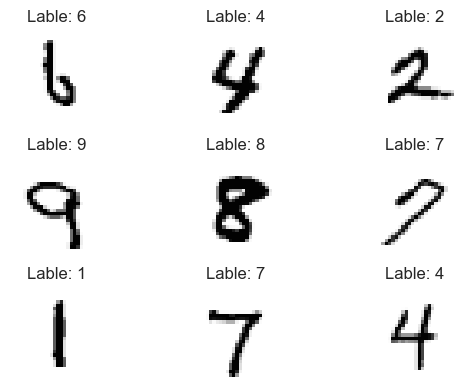

In [5]:
random_glance(df)

## Preprocess data

In [6]:
def preprocess(df):
    '''
    Parse the features and targets, and maybe feature scaling if needed
    '''
    labels = df[0]
    features = df.loc[:, 1:]
    features /= 255
    return features, labels

In [7]:
# Choose 7500 examples as our training set and remaining 2500 as validation set
training_set, training_targets = preprocess(df[:7500])
validation_set, validation_targets = preprocess(df[7500:])

## Build a logistic regressor
**use one-vs-all method to classifiy each digit**

In [8]:
def construct_feature_columns():
    '''return a set of feature columns'''
    return set([tf.feature_column.numeric_column('pixels', shape = 784)])

In [9]:
import pdb

In [10]:
def create_input_fn(features, training = True, labels = None, batch_size = 1, num_epochs = None, shuffle = True):
    '''
    Create input function for .train(), .predict(), etc.
    Returns a function that returns batches of features and labels
    '''
    if labels is None:
        labels = np.zeros(len(features))
    def _input_fn(training = True, num_epochs = None, shuffle = True):
        '''Input pipelines are reset with each call to .train(). To ensure model
        gets a good sampling of data, even when number of steps is small, we 
        shuffle all the data before creating the Dataset object
        '''
        if training:
            idx = np.random.permutation(features.index)
            raw_labels = np.array(labels[idx])
        else:
            idx = features.index
            raw_labels = labels.copy()
        raw_features = {'pixels': features.reindex(idx)}
        
        ds = Dataset.from_tensor_slices((raw_features, raw_labels))
        ds = ds.batch(batch_size).repeat(num_epochs)
        
        if training and shuffle:
            ds = ds.shuffle(10000)
            
        # return the next batch of data
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    if training:
        return _input_fn
    else:
        return lambda: _input_fn(training = False)

In [11]:
def train_logistic_classifier(learning_rate, steps, batch_size,
                             ts, tt, vs, vt, periods = 10):
    step_size = steps//periods
    my_optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    
    training_input_fn = create_input_fn(ts, True, tt, batch_size)
    predict_input_fn = create_input_fn(ts, False, batch_size = batch_size)
    validation_input_fn = create_input_fn(vs, False, batch_size = batch_size)
    
    logistic_classifier = tf.estimator.LinearClassifier(
                    feature_columns = construct_feature_columns(),
                    n_classes = 10, optimizer = my_optimizer,
                    config=tf.estimator.RunConfig(keep_checkpoint_max=1)
    )
    training_log_loss = []
    val_log_loss = []
    print('Training DNN regressor\nlog loss is:')
    for i in range(periods):
        logistic_classifier.train(input_fn = training_input_fn,
                                 steps = step_size)
        predicts = list(logistic_classifier.predict(input_fn = predict_input_fn))
        probs = np.array([item['probabilities'] for item in predicts])
        pred_class = np.array([item['class_ids'][0] for item in predicts])
        pred_one_hot = tf.keras.utils.to_catergorical(pred_class, 10)
        
        vals = list(logistic_classifier.predict(input_fn = validation_input_fn))
        val_probs = np.array([item['probabilities'] for item in vals])
        val_pred_class = np.array([item['class_ids'][0] for item in vals])
        val_pred_one_hot = tf.keras.utils.to_catergorical(val_pred_class, 10)
        
        training_log_loss.append(metrics.log_loss(tt, pred_one_hot))
        val_log_loss.append(metrics.log_loss(vt, val_pred_one_hot))
        
        print('Preriods %d: training log loss ->%.2f, validation log loss -> %.2f ' 
              %(i, training_log_loss[-1], val_log_loss[-1]))
    print('Model training finished')
    # remove the event files from disk to save disk space
    _ = map(os.remove, glob.glob(os.path.join(logistic_classifier.model_dir, 'events.out.tfevents*')))
    
    final_predict = logistic_classifier.predict(input_fn = predict_input_fn)
    final_predict = np.array([item['class_ids'][0] for item in final_predict])
    
    accuracy = metrics.accuracy_score(vt, final_predict)
    
    fig = plt.figure(dpi = 100)
    plt.plot(training_log_loss, label = 'Training')
    plt.plot(val_log_loss, label = 'Validation')
    plt.legend()
    plt.xlable('period')
    plt.ylabel('log loss')
    plt.tight_layout()
    
    conf_mat = metrics.confusion_matrix(vt, final_predict)
    conf_mat_norm = conf_mat.astype('float')/conf_mat.sum(axis = 1)[:, np.newaxis]
    ax = sns.heatmap(conf_mat_norm, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    return logistic_classifier

In [12]:
classifier = train_logistic_classifier(0.02, 10, 1,
                                      training_set, training_targets,
                                      validation_set, validation_targets)

Training DNN regressor
log loss is:


KeyboardInterrupt: 

In [16]:
glob.glob?

In [17]:
os.path.dirname(tf.__file__)

'/Users/yuzhang/programs/anaconda/envs/py3/lib/python3.6/site-packages/tensorflow'